# Variable Selection

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import BaggingRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def run_model(model, X, y, num_iterations):
    rmse_scores = []
    r2_scores = []
    rand_state = np.random.randint(0, num_iterations*10, num_iterations)
    for i in rand_state:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
        my_model = model.fit(X_train, y_train)
        pred = my_model.predict(X_test)
        r2_scores.append(my_model.score(X_test, y_test))
        rmse_scores.append(rmse(pred, y_test))
    scores = list(zip(rand_state, rmse_scores, r2_scores))
    sorted_scores = sorted(scores, key=lambda x: x[1])
    return sorted_scores, rmse_scores, r2_scores

In [3]:
def rmse(pred, y):
    n = len(y)
    RMSE = np.sqrt(sum((pred - y)**2) / n)
    return RMSE

In [4]:
reduced = pd.read_csv("../reduced_noot.csv")
reduced = reduced.drop(columns = reduced.columns[0])

In [5]:
X = reduced.drop(columns="scores")
y = reduced["scores"]

In [7]:
lr = LinearRegression()
var_1 = X[["predscores", "tmhalfsc", "opphalfsc", "psd", "sack_yd_pct", "int_pct", "sack_pct"]]
var_2 = X[["predscores", "tmhalfsc", "opphalfsc", "psd", "yaca", "airya"]]
var_3 = X[["predscores", "tmhalfsc", "psd", "sack_yd_pct", "int_pct", "sack_pct"]]
var_4 = X[["predscores", "tmhalfsc"]]
var_list = [X, var_1, var_2, var_3, var_4]

In [8]:
scores = list()
min_rmse = list()
avg_rmse = list()
max_rmse = list()
min_r2 = list()
avg_r2 = list()
max_r2 = list()
for i in range(len(var_list)):
    scs, rmse_sc, r2_sc = run_model(lr, var_list[i], y, 1000)
    scores.append((i, scs[0]))
    min_rmse.append((i, round(min(rmse_sc), 3)))
    max_rmse.append((i, round(max(rmse_sc), 3)))
    avg_rmse.append((i, round(np.mean(rmse_sc), 3)))
    min_r2.append((i, round(min(r2_sc), 3)))
    max_r2.append((i, round(max(r2_sc), 3)))
    avg_r2.append((i, round(np.mean(r2_sc), 3)))

In [9]:
gathered = list()
for i in range(len(avg_rmse)):
    gathered.append((i, avg_rmse[i][1], min_rmse[i][1], max_rmse[i][1], 
                     avg_r2[i][1], min_r2[i][1], max_r2[i][1]))
gathered_sorted = sorted(gathered, key=lambda sc: sc[1])

In [10]:
summary = pd.DataFrame(gathered_sorted, columns=["Var", "Average RMSE", "Min RMSE", "Max RMSE",
                                                 "Average R^2", "Min R^2", "Max R^2"])
summary

,Var,Average RMSE,Min RMSE,Max RMSE,Average R^2,Min R^2,Max R^2
0,1,6.766,6.283,7.219,0.556,0.465,0.622
1,4,6.775,6.289,7.233,0.555,0.489,0.618
2,2,6.784,6.246,7.262,0.554,0.483,0.630
3,3,6.785,6.299,7.297,0.554,0.470,0.617
4,0,6.788,6.331,7.266,0.552,0.455,0.618


In [11]:
var = var_list[gathered_sorted[0][0]]
t_X_train, t_X_test, t_y_train, t_y_test = train_test_split(var, y, test_size=0.25)
lin_reg = LinearRegression()
bag = BaggingRegressor(lin_reg, bootstrap=True, n_estimators=60, max_samples=0.95)
bag_scores, bag_rmse, bag_r2 = run_model(bag, var, y, 10)

In [12]:
bag_gathered = [(gathered_sorted[0][0], np.mean(bag_rmse), min(bag_rmse), max(bag_rmse), 
                np.mean(bag_r2), min(bag_r2), max(bag_r2))]

In [14]:
bag_summary = pd.DataFrame(bag_gathered, columns=["Var", "Average RMSE", "Min RMSE", "Max RMSE", 
                                                  "Average R^2", "Min R^2", "Max R^2"])
bag_summary

,Var,Average RMSE,Min RMSE,Max RMSE,Average R^2,Min R^2,Max R^2
0,1,6.767391,6.465734,7.199544,0.562284,0.516056,0.590651


# Cross Validation Visualization

In [15]:
train_size, train_scores, valid_scores = learning_curve(estimator=bag, X=t_X_train, y=t_y_train, 
                                                        train_sizes=np.arange(0.75, 1.0, 0.01), cv=10, 
                                                        n_jobs=-1)

In [16]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

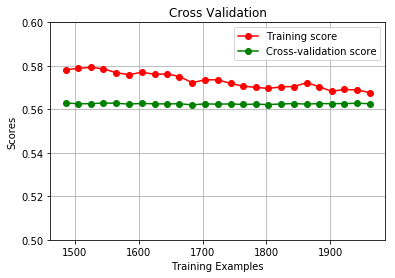

In [17]:
plt.figure()
plt.title("Cross Validation")
plt.xlabel("Training Examples")
plt.ylabel("Scores")
plt.grid()
plt.plot(train_size, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_size, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim(0.5, 0.6)
plot = plt.legend(loc="best")

# Grid Search over Bagging Regressor

In [18]:
bag_search = {"n_estimators":np.arange(58, 63, 1), "max_samples":np.arange(0.9, 0.96, 0.01)}

In [19]:
bagger = BaggingRegressor(lin_reg, bootstrap=True)
bag_gs = GridSearchCV(bagger, bag_search, cv=10, n_jobs=-1)

In [20]:
good_estimators = list()

In [21]:
for i in range(0, 20):
    var_X_train, var_X_test, var_y_train, var_y_test = train_test_split(var, y, test_size=0.25)
    bag_gs.fit(var_X_train, var_y_train)
    gs_r2 = bag_gs.best_estimator_.score(var_X_test, var_y_test)
    gs_rmse = rmse(bag_gs.best_estimator_.predict(var_X_test), var_y_test)
    if gs_r2 > 0.56:
        good_estimators.append(bag_gs.best_estimator_)

In [22]:
est = list()
samples = list()
for model in good_estimators:
    samples.append(model.get_params()["max_samples"])
    est.append(model.get_params()["n_estimators"])

In [23]:
num_est = int(np.mean(est))
num_samples = np.mean(samples)

In [24]:
print(f"Number of Estimators: {num_est}")
print(f"Ratio of Samples per bag: {num_samples}")

Number of Estimators: 59
Ratio of Samples per bag: 0.9266666666666666


# Final Model

I think var_1 or var_2 gives the most consistent results. Use num_est for n_estimators and num_samples for max_samples (approximately 60, 0.92 respectively).

In [47]:
var_1 = X[["predscores", "tmhalfsc", "opphalfsc", "psd", "sack_yd_pct", "int_pct", "sack_pct"]]
# var_2 = X[["predscores", "tmhalfsc", "opphalfsc", "psd", "yaca", "airya"]]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(var_1, y, test_size=0.25)

In [40]:
final_bag = BaggingRegressor(LinearRegression(), n_estimators=60, max_samples=0.92, 
                             bootstrap=True, n_jobs=-1)
final_bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.92, n_estimators=60, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [41]:
all_coefs = []
for coef in range(len(final_bag.estimators_[0].coef_)):
    all_coefs.append(list())
for est in final_bag.estimators_:
    for coef in range(len(est.coef_)):
        all_coefs[coef].append(est.coef_[coef])
avg_coefs = [np.mean(c) for c in all_coefs]
coefs = var_2.columns
list(zip(coefs, avg_coefs))

[('predscores', 0.5527009284591632),
 ('tmhalfsc', 0.9262828882891901),
 ('opphalfsc', 0.03729223587860215),
 ('psd', -0.0024721784040361043),
 ('yaca', 0.021980557949145472),
 ('airya', -5.640029056032687)]

In [42]:
bag_pred = final_bag.predict(X_test)
for s in range(len(bag_pred)):
    bag_pred[s] = round(bag_pred[s], 2)
bag_rmse = rmse(bag_pred, y_test)
bag_r2 = final_bag.score(X_test, y_test)

In [43]:
print(f"Final RMSE: {bag_rmse:.4f}")
print(f"Final R^2: {bag_r2:.4f}")

Final RMSE: 6.6403
Final R^2: 0.5623


In [44]:
resids = y_test - bag_pred

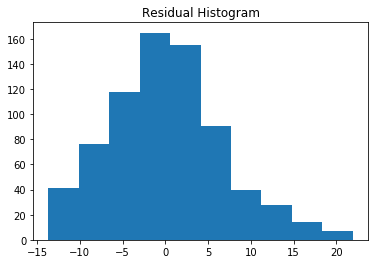

In [45]:
plt.hist(resids)
plt.title("Residual Histogram")
plt.show()

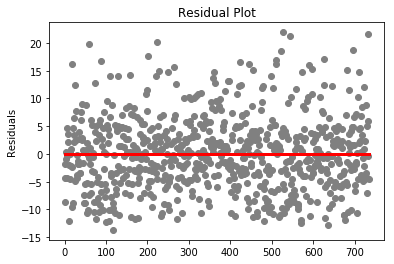

In [46]:
plt.scatter(range(len(resids)), resids, color="grey")
plt.plot(range(len(resids)), np.zeros(len(resids)), color="red", linewidth=3)
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()